In [2]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# return directory
print(os.listdir('/kaggle/input/'))

['skin-cancer-mnist-ham10000']


In [3]:
print(os.listdir('../input/skin-cancer-mnist-ham10000'))

['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [4]:
data_dir = '../input/skin-cancer-mnist-ham10000'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [6]:
# Values stored to save future run time
norm_mean = [0.7630392, 0.5456477, 0.57004845]
norm_std = [0.1409286, 0.15261266, 0.16997074]

In [7]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [8]:
# Determine how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [9]:
# Identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# Apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated


In [10]:
df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [11]:
# Filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [12]:
# Create a val set using df as none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [13]:
df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: count, dtype: int64

In [14]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filter out training rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [15]:
df_train['cell_type_idx'].value_counts()

cell_type_idx
4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: count, dtype: int64

In [16]:
df_val['cell_type'].value_counts()

cell_type
Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: count, dtype: int64

In [17]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]
for i in range(7):
    if data_aug_rate[i]:
        # Create a new DataFrame by repeating rows for augmentation
        augmented_data = pd.concat([df_train.loc[df_train['cell_type_idx'] == i, :]] * (data_aug_rate[i] - 1), ignore_index=True)
        
        # Concatenate the augmented data to the original DataFrame
        df_train = pd.concat([df_train, augmented_data], ignore_index=True)

# Check the value counts of each cell type after augmentation
df_train['cell_type'].value_counts()


cell_type
Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: count, dtype: int64

In [18]:
# Split the test set again in a validation set and a true test set:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [19]:
print(len(df_test))
df_test['cell_type'].value_counts()

552


cell_type
Melanocytic nevi                  444
Benign keratosis-like lesions      47
dermatofibroma                     20
Basal cell carcinoma               15
Actinic keratoses                  12
Vascular lesions                    8
Dermatofibroma                      6
Name: count, dtype: int64

In [20]:
# feature_extract is a boolean that defines finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, res
        net101
        """
        model_ft = models.resnet101(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [22]:
model_name = "resnet"
num_classes = 7
feature_extract = False
# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
#device = torch.device('cpu') # If using cpu
# Put the model on the device:
model = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 200MB/s]  


In [23]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [24]:
# Define a pytorch dataloader for dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [25]:
# Define the training set using the table train_df and using the defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Same for the test set:
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [26]:
# set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [27]:
# this function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [29]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [30]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1124], [train loss 1.62609], [train acc 0.38312]
[epoch 1], [iter 200 / 1124], [train loss 1.44311], [train acc 0.45266]
[epoch 1], [iter 300 / 1124], [train loss 1.37843], [train acc 0.48125]
[epoch 1], [iter 400 / 1124], [train loss 1.31257], [train acc 0.50805]
[epoch 1], [iter 500 / 1124], [train loss 1.27117], [train acc 0.52331]
[epoch 1], [iter 600 / 1124], [train loss 1.23075], [train acc 0.53901]
[epoch 1], [iter 700 / 1124], [train loss 1.19415], [train acc 0.55420]
[epoch 1], [iter 800 / 1124], [train loss 1.15954], [train acc 0.56730]
[epoch 1], [iter 900 / 1124], [train loss 1.12832], [train acc 0.57983]
[epoch 1], [iter 1000 / 1124], [train loss 1.10946], [train acc 0.58584]
[epoch 1], [iter 1100 / 1124], [train loss 1.08393], [train acc 0.59543]



0it [00:00, ?it/s]
1it [00:01,  1.31s/it]
2it [00:01,  1.56it/s]
3it [00:01,  2.31it/s]
4it [00:01,  3.02it/s]
5it [00:02,  2.46it/s]
6it [00:02,  3.05it/s]
7it [00:02,  3.55it/s]
8it [00:02,  4.03it/s]
9it [00:03,  2.51it/s]
10it [00:03,  3.05it/s]
11it [00:04,  3.51it/s]
12it [00:04,  3.97it/s]
13it [00:04,  2.92it/s]
14it [00:04,  3.43it/s]
15it [00:05,  3.88it/s]
16it [00:05,  4.30it/s]
17it [00:05,  4.30it/s]
18it [00:05,  3.17it/s]
 10%|█         | 1/10 [10:46<1:36:59, 646.58s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.71592], [val acc 0.74479]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.71592], [val acc 0.74479]
*****************************************************
[epoch 2], [iter 100 / 1124], [train loss 0.78433], [train acc 0.69312]
[epoch 2], [iter 200 / 1124], [train loss 0.78761], [train acc 0.70266]
[epoch 2], [iter 300 / 1124], [train loss 0.78435], [train acc 0.70479]
[epoch 2], [iter 400 / 1124], [train loss 0.76438], [train acc 0.71320]
[epoch 2], [iter 500 / 1124], [train loss 0.75800], [train acc 0.71469]
[epoch 2], [iter 600 / 1124], [train loss 0.75027], [train acc 0.71708]
[epoch 2], [iter 700 / 1124], [train loss 0.74401], [train acc 0.71946]
[epoch 2], [iter 800 / 1124], [train loss 0.73507], [train acc 0.72270]
[epoch 2], [iter 900 / 1124], [train loss 0.72947], [train acc 0.72465]
[epoch 2], 


0it [00:00, ?it/s]
1it [00:01,  1.01s/it]
2it [00:01,  1.93it/s]
3it [00:01,  2.70it/s]
4it [00:01,  3.41it/s]
5it [00:01,  3.43it/s]
6it [00:02,  3.96it/s]
7it [00:02,  4.34it/s]
8it [00:02,  4.71it/s]
9it [00:02,  3.94it/s]
10it [00:02,  4.36it/s]
11it [00:03,  4.62it/s]
12it [00:03,  4.92it/s]
13it [00:03,  4.03it/s]
14it [00:03,  4.44it/s]
15it [00:03,  4.71it/s]
16it [00:04,  4.98it/s]
18it [00:04,  4.09it/s]
 20%|██        | 2/10 [21:36<1:26:27, 648.40s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.43754], [val acc 0.85243]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.43754], [val acc 0.85243]
*****************************************************
[epoch 3], [iter 100 / 1124], [train loss 0.65333], [train acc 0.76000]
[epoch 3], [iter 200 / 1124], [train loss 0.63607], [train acc 0.76422]
[epoch 3], [iter 300 / 1124], [train loss 0.62625], [train acc 0.76427]
[epoch 3], [iter 400 / 1124], [train loss 0.61748], [train acc 0.76641]
[epoch 3], [iter 500 / 1124], [train loss 0.61357], [train acc 0.76744]
[epoch 3], [iter 600 / 1124], [train loss 0.61262], [train acc 0.76693]
[epoch 3], [iter 700 / 1124], [train loss 0.60903], [train acc 0.76871]
[epoch 3], [iter 800 / 1124], [train loss 0.61317], [train acc 0.76754]
[epoch 3], [iter 900 / 1124], [train loss 0.61195], [train acc 0.76757]
[epoch 3], 


0it [00:00, ?it/s]
1it [00:00,  1.06it/s]
2it [00:01,  2.05it/s]
3it [00:01,  2.87it/s]
4it [00:01,  3.56it/s]
5it [00:01,  3.02it/s]
6it [00:02,  3.60it/s]
7it [00:02,  4.03it/s]
8it [00:02,  4.43it/s]
9it [00:02,  3.87it/s]
10it [00:02,  4.31it/s]
11it [00:03,  4.57it/s]
12it [00:03,  4.87it/s]
13it [00:03,  3.81it/s]
14it [00:03,  4.26it/s]
15it [00:04,  4.54it/s]
16it [00:04,  4.87it/s]
18it [00:04,  4.01it/s]
 30%|███       | 3/10 [32:22<1:15:30, 647.23s/it]

------------------------------------------------------------
[epoch 3], [val loss 0.43202], [val acc 0.83160]
------------------------------------------------------------
[epoch 4], [iter 100 / 1124], [train loss 0.60515], [train acc 0.77438]
[epoch 4], [iter 200 / 1124], [train loss 0.55517], [train acc 0.79047]
[epoch 4], [iter 300 / 1124], [train loss 0.54279], [train acc 0.79563]
[epoch 4], [iter 400 / 1124], [train loss 0.53385], [train acc 0.79703]
[epoch 4], [iter 500 / 1124], [train loss 0.53789], [train acc 0.79556]
[epoch 4], [iter 600 / 1124], [train loss 0.53646], [train acc 0.79547]
[epoch 4], [iter 700 / 1124], [train loss 0.53245], [train acc 0.79772]
[epoch 4], [iter 800 / 1124], [train loss 0.52859], [train acc 0.79945]
[epoch 4], [iter 900 / 1124], [train loss 0.52363], [train acc 0.80115]
[epoch 4], [iter 1000 / 1124], [train loss 0.52332], [train acc 0.80053]
[epoch 4], [iter 1100 / 1124], [train loss 0.51931], [train acc 0.80236]



0it [00:00, ?it/s]
1it [00:00,  1.08it/s]
2it [00:01,  2.05it/s]
3it [00:01,  2.84it/s]
4it [00:01,  3.55it/s]
5it [00:01,  3.34it/s]
6it [00:01,  3.90it/s]
7it [00:02,  4.28it/s]
8it [00:02,  4.67it/s]
9it [00:02,  3.78it/s]
10it [00:02,  4.25it/s]
11it [00:03,  4.53it/s]
12it [00:03,  4.86it/s]
13it [00:03,  4.09it/s]
14it [00:03,  4.51it/s]
15it [00:03,  4.81it/s]
16it [00:04,  5.06it/s]
18it [00:04,  4.13it/s]
 40%|████      | 4/10 [43:06<1:04:36, 646.11s/it]

------------------------------------------------------------
[epoch 4], [val loss 0.39112], [val acc 0.84449]
------------------------------------------------------------
[epoch 5], [iter 100 / 1124], [train loss 0.45232], [train acc 0.82719]
[epoch 5], [iter 200 / 1124], [train loss 0.46400], [train acc 0.82297]
[epoch 5], [iter 300 / 1124], [train loss 0.47433], [train acc 0.81896]
[epoch 5], [iter 400 / 1124], [train loss 0.47890], [train acc 0.81633]
[epoch 5], [iter 500 / 1124], [train loss 0.47574], [train acc 0.81706]
[epoch 5], [iter 600 / 1124], [train loss 0.47358], [train acc 0.81812]
[epoch 5], [iter 700 / 1124], [train loss 0.47012], [train acc 0.81946]
[epoch 5], [iter 800 / 1124], [train loss 0.46903], [train acc 0.82039]
[epoch 5], [iter 900 / 1124], [train loss 0.46498], [train acc 0.82135]
[epoch 5], [iter 1000 / 1124], [train loss 0.46027], [train acc 0.82337]
[epoch 5], [iter 1100 / 1124], [train loss 0.46273], [train acc 0.82179]



0it [00:00, ?it/s]
1it [00:00,  1.07it/s]
2it [00:01,  2.06it/s]
3it [00:01,  2.87it/s]
4it [00:01,  3.60it/s]
5it [00:01,  3.38it/s]
6it [00:01,  3.94it/s]
7it [00:02,  4.27it/s]
8it [00:02,  4.65it/s]
9it [00:02,  4.05it/s]
10it [00:02,  4.47it/s]
11it [00:03,  4.71it/s]
12it [00:03,  4.99it/s]
13it [00:03,  4.13it/s]
14it [00:03,  4.54it/s]
15it [00:03,  4.78it/s]
16it [00:04,  5.06it/s]
18it [00:04,  4.17it/s]
 50%|█████     | 5/10 [53:48<53:44, 644.81s/it]  

------------------------------------------------------------
[epoch 5], [val loss 0.36804], [val acc 0.86979]
------------------------------------------------------------
*****************************************************
best record: [epoch 5], [val loss 0.36804], [val acc 0.86979]
*****************************************************
[epoch 6], [iter 100 / 1124], [train loss 0.42473], [train acc 0.83062]
[epoch 6], [iter 200 / 1124], [train loss 0.41236], [train acc 0.83750]
[epoch 6], [iter 300 / 1124], [train loss 0.42420], [train acc 0.83417]
[epoch 6], [iter 400 / 1124], [train loss 0.42436], [train acc 0.83359]
[epoch 6], [iter 500 / 1124], [train loss 0.42588], [train acc 0.83313]
[epoch 6], [iter 600 / 1124], [train loss 0.41917], [train acc 0.83656]
[epoch 6], [iter 700 / 1124], [train loss 0.41774], [train acc 0.83777]
[epoch 6], [iter 800 / 1124], [train loss 0.41683], [train acc 0.83828]
[epoch 6], [iter 900 / 1124], [train loss 0.41530], [train acc 0.83892]
[epoch 6], 


0it [00:00, ?it/s]
1it [00:00,  1.09it/s]
2it [00:01,  2.10it/s]
3it [00:01,  2.91it/s]
4it [00:01,  3.64it/s]
5it [00:01,  3.36it/s]
6it [00:01,  3.91it/s]
7it [00:02,  4.31it/s]
8it [00:02,  4.65it/s]
9it [00:02,  3.94it/s]
10it [00:02,  4.37it/s]
11it [00:03,  4.64it/s]
12it [00:03,  4.92it/s]
13it [00:03,  3.74it/s]
14it [00:03,  4.21it/s]
15it [00:03,  4.55it/s]
16it [00:04,  4.86it/s]
18it [00:04,  4.10it/s]
 60%|██████    | 6/10 [1:04:30<42:54, 643.53s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.35626], [val acc 0.86806]
------------------------------------------------------------
[epoch 7], [iter 100 / 1124], [train loss 0.37538], [train acc 0.85281]
[epoch 7], [iter 200 / 1124], [train loss 0.37372], [train acc 0.85484]
[epoch 7], [iter 300 / 1124], [train loss 0.36983], [train acc 0.85448]
[epoch 7], [iter 400 / 1124], [train loss 0.37843], [train acc 0.85305]
[epoch 7], [iter 500 / 1124], [train loss 0.37552], [train acc 0.85244]
[epoch 7], [iter 600 / 1124], [train loss 0.37478], [train acc 0.85255]
[epoch 7], [iter 700 / 1124], [train loss 0.37401], [train acc 0.85330]
[epoch 7], [iter 800 / 1124], [train loss 0.37350], [train acc 0.85297]
[epoch 7], [iter 900 / 1124], [train loss 0.37359], [train acc 0.85351]
[epoch 7], [iter 1000 / 1124], [train loss 0.37276], [train acc 0.85381]
[epoch 7], [iter 1100 / 1124], [train loss 0.37000], [train acc 0.85503]



0it [00:00, ?it/s]
1it [00:00,  1.07it/s]
2it [00:01,  2.05it/s]
3it [00:01,  2.83it/s]
4it [00:01,  3.54it/s]
5it [00:01,  3.42it/s]
6it [00:01,  3.97it/s]
7it [00:02,  4.33it/s]
8it [00:02,  4.71it/s]
9it [00:02,  3.81it/s]
10it [00:02,  4.26it/s]
11it [00:03,  4.52it/s]
12it [00:03,  4.86it/s]
13it [00:03,  3.73it/s]
14it [00:03,  4.20it/s]
15it [00:03,  4.50it/s]
16it [00:04,  4.84it/s]
18it [00:04,  4.07it/s]
 70%|███████   | 7/10 [1:15:10<32:07, 642.50s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.47744], [val acc 0.81597]
------------------------------------------------------------
[epoch 8], [iter 100 / 1124], [train loss 0.32135], [train acc 0.88344]
[epoch 8], [iter 200 / 1124], [train loss 0.33352], [train acc 0.87375]
[epoch 8], [iter 300 / 1124], [train loss 0.32825], [train acc 0.87500]
[epoch 8], [iter 400 / 1124], [train loss 0.32691], [train acc 0.87492]
[epoch 8], [iter 500 / 1124], [train loss 0.32354], [train acc 0.87531]
[epoch 8], [iter 600 / 1124], [train loss 0.32313], [train acc 0.87604]
[epoch 8], [iter 700 / 1124], [train loss 0.32468], [train acc 0.87540]
[epoch 8], [iter 800 / 1124], [train loss 0.32455], [train acc 0.87523]
[epoch 8], [iter 900 / 1124], [train loss 0.32891], [train acc 0.87354]
[epoch 8], [iter 1000 / 1124], [train loss 0.32705], [train acc 0.87406]
[epoch 8], [iter 1100 / 1124], [train loss 0.32806], [train acc 0.87378]



0it [00:00, ?it/s]
1it [00:00,  1.10it/s]
2it [00:01,  2.10it/s]
3it [00:01,  2.90it/s]
4it [00:01,  3.62it/s]
5it [00:01,  3.28it/s]
6it [00:01,  3.85it/s]
7it [00:02,  4.25it/s]
8it [00:02,  4.66it/s]
9it [00:02,  3.91it/s]
10it [00:02,  4.34it/s]
11it [00:03,  4.62it/s]
12it [00:03,  4.93it/s]
13it [00:03,  4.21it/s]
14it [00:03,  4.61it/s]
15it [00:03,  4.89it/s]
16it [00:04,  5.16it/s]
18it [00:04,  4.19it/s]
 80%|████████  | 8/10 [1:25:48<21:22, 641.09s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.41422], [val acc 0.85938]
------------------------------------------------------------
[epoch 9], [iter 100 / 1124], [train loss 0.28662], [train acc 0.88344]
[epoch 9], [iter 200 / 1124], [train loss 0.31884], [train acc 0.87703]
[epoch 9], [iter 300 / 1124], [train loss 0.32511], [train acc 0.87385]
[epoch 9], [iter 400 / 1124], [train loss 0.31959], [train acc 0.87773]
[epoch 9], [iter 500 / 1124], [train loss 0.32270], [train acc 0.87569]
[epoch 9], [iter 600 / 1124], [train loss 0.32006], [train acc 0.87734]
[epoch 9], [iter 700 / 1124], [train loss 0.31641], [train acc 0.87835]
[epoch 9], [iter 800 / 1124], [train loss 0.31644], [train acc 0.87820]
[epoch 9], [iter 900 / 1124], [train loss 0.31134], [train acc 0.87993]
[epoch 9], [iter 1000 / 1124], [train loss 0.31070], [train acc 0.87959]
[epoch 9], [iter 1100 / 1124], [train loss 0.30938], [train acc 0.88020]



0it [00:00, ?it/s]
1it [00:00,  1.11it/s]
2it [00:01,  2.11it/s]
3it [00:01,  2.93it/s]
4it [00:01,  3.64it/s]
5it [00:01,  3.28it/s]
6it [00:01,  3.84it/s]
7it [00:02,  4.25it/s]
8it [00:02,  4.65it/s]
9it [00:02,  4.12it/s]
10it [00:02,  4.51it/s]
11it [00:02,  4.75it/s]
12it [00:03,  5.02it/s]
13it [00:03,  4.20it/s]
14it [00:03,  4.59it/s]
15it [00:03,  4.87it/s]
16it [00:04,  5.15it/s]
18it [00:04,  4.22it/s]
 90%|█████████ | 9/10 [1:36:24<10:39, 639.49s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.38527], [val acc 0.87500]
------------------------------------------------------------
*****************************************************
best record: [epoch 9], [val loss 0.38527], [val acc 0.87500]
*****************************************************
[epoch 10], [iter 100 / 1124], [train loss 0.26415], [train acc 0.90156]
[epoch 10], [iter 200 / 1124], [train loss 0.27423], [train acc 0.89656]
[epoch 10], [iter 300 / 1124], [train loss 0.27711], [train acc 0.89573]
[epoch 10], [iter 400 / 1124], [train loss 0.27845], [train acc 0.89484]
[epoch 10], [iter 500 / 1124], [train loss 0.27561], [train acc 0.89563]
[epoch 10], [iter 600 / 1124], [train loss 0.27487], [train acc 0.89526]
[epoch 10], [iter 700 / 1124], [train loss 0.27335], [train acc 0.89638]
[epoch 10], [iter 800 / 1124], [train loss 0.27109], [train acc 0.89668]
[epoch 10], [iter 900 / 1124], [train loss 0.27144], [train acc 0.89649]
[e


0it [00:00, ?it/s]
1it [00:00,  1.06it/s]
2it [00:01,  2.04it/s]
3it [00:01,  2.86it/s]
4it [00:01,  3.59it/s]
5it [00:01,  3.26it/s]
6it [00:01,  3.85it/s]
7it [00:02,  4.24it/s]
8it [00:02,  4.63it/s]
9it [00:02,  4.02it/s]
10it [00:02,  4.44it/s]
11it [00:03,  4.69it/s]
12it [00:03,  4.98it/s]
13it [00:03,  4.28it/s]
14it [00:03,  4.67it/s]
15it [00:03,  4.92it/s]
16it [00:04,  5.18it/s]
18it [00:04,  4.18it/s]
100%|██████████| 10/10 [1:46:58<00:00, 641.89s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.43347], [val acc 0.84896]
------------------------------------------------------------


In [31]:
torch.save(model.state_dict(), "/kaggle/working/resnet101_ham10000_v2.pth")


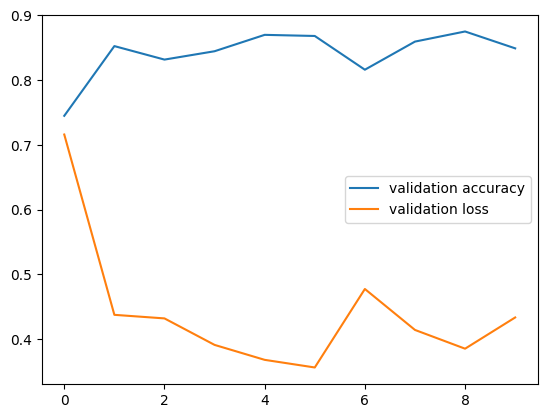

In [32]:
fig = plt.figure(num = 1)
fig2 = fig.add_subplot(1,1,1)
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.plot(total_loss_val, label = 'validation loss')

plt.legend()
plt.show()

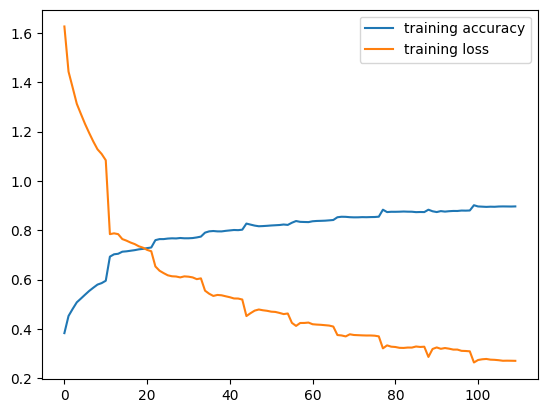

In [33]:
fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')

plt.legend()
plt.show()

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

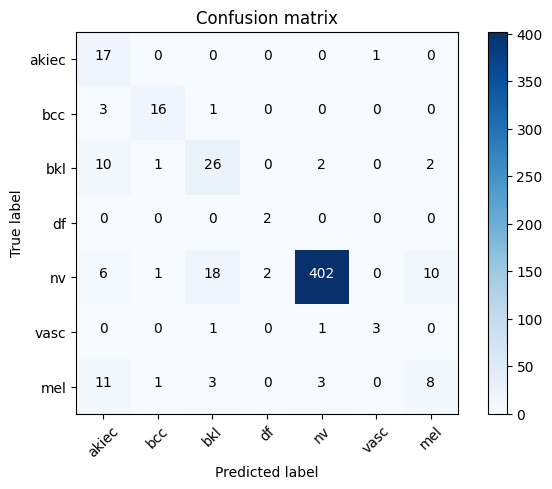

In [35]:
# Validation data evaluation

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

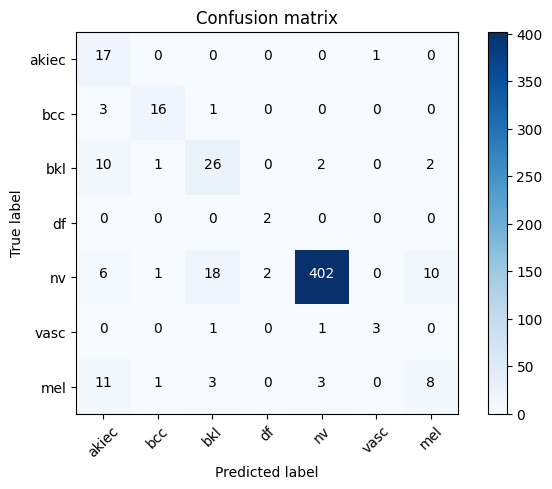

In [36]:
# Test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [37]:
# Generate a validation classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.36      0.94      0.52        18
         bcc       0.84      0.80      0.82        20
         bkl       0.53      0.63      0.58        41
          df       0.50      1.00      0.67         2
          nv       0.99      0.92      0.95       439
        vasc       0.75      0.60      0.67         5
         mel       0.40      0.31      0.35        26

    accuracy                           0.86       551
   macro avg       0.62      0.74      0.65       551
weighted avg       0.89      0.86      0.87       551



In [38]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.32      1.00      0.48        12
         bcc       0.78      0.47      0.58        15
         bkl       0.56      0.62      0.59        47
          df       0.42      0.83      0.56         6
          nv       0.98      0.92      0.95       444
        vasc       1.00      0.75      0.86         8
         mel       0.47      0.45      0.46        20

    accuracy                           0.86       552
   macro avg       0.65      0.72      0.64       552
weighted avg       0.90      0.86      0.87       552



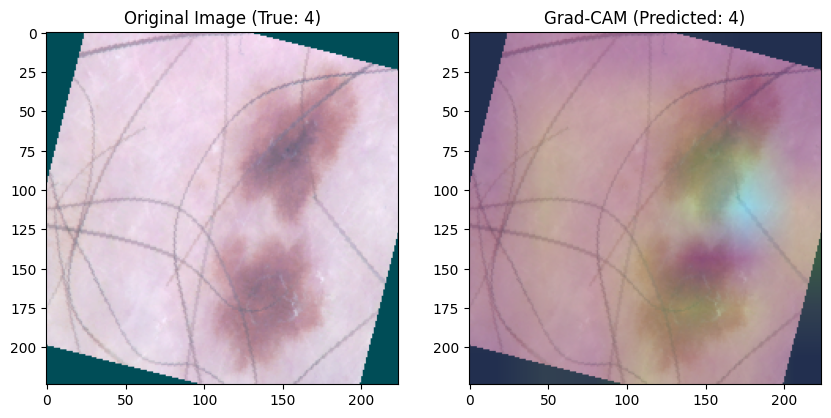

In [45]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activation = None

        # Register forward hook
        def forward_hook(module, input, output):
            self.activation = output

        # Register backward hook using the new PyTorch API
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)  # Updated API

    def generate(self, input_tensor, target_class):
        # Forward pass
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Backward pass for target class
        class_score = output[:, target_class]
        class_score.backward()

        # Get gradients and activation
        gradients = self.gradients.cpu().detach().numpy()
        activation = self.activation.cpu().detach().numpy()

        # Compute Grad-CAM heatmap
        weights = np.mean(gradients, axis=(2, 3))  # Global Average Pooling
        cam = np.zeros(activation.shape[2:], dtype=np.float32)

        for i, w in enumerate(weights[0]):
            cam += w * activation[0, i, :, :]

        # Normalize heatmap
        cam = np.maximum(cam, 0)  # Remove negative values
        cam = cam / (np.max(cam) + 1e-8)  # Avoid division by zero
        cam = np.uint8(255 * cam)  # Convert to uint8

        # Apply color map
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_VIRIDIS)  # Better than JET for medical images
        return heatmap

def overlay_heatmap(original_image, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap on the original image."""
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))  # Resize to match input image
    superimposed_img = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)  # Blend heatmap with image
    return superimposed_img

# ---- Sample Usage ----
# Assuming you have 'model', 'input_tensor', and a target layer in ResNet
target_layer = model.layer4[-1]  # Correct target layer for ResNet
grad_cam = GradCAM(model, target_layer)

heatmap = grad_cam.generate(input_tensor, target_class=4)  # Adjust target class accordingly

# Convert input tensor to image format
input_image = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Normalize to [0,1]
input_image = (input_image * 255).astype(np.uint8)

# Overlay and visualize
superimposed_img = overlay_heatmap(input_image, heatmap)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title(f"Original Image (True: {4})")  # Update with actual label

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM (Predicted: {4})")  # Update with actual prediction

plt.show()


In [56]:
import cv2
import numpy as np

def evaluate_gradcam(heatmap, ground_truth_mask, threshold=0.5):
    """Evaluates Grad-CAM by computing IoU with the ground truth mask."""
    
    # Resize heatmap to match the mask size
    heatmap_resized = cv2.resize(heatmap, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]))

    # Convert heatmap to grayscale (if it's colored)
    if len(heatmap_resized.shape) == 3:
        heatmap_resized = cv2.cvtColor(heatmap_resized, cv2.COLOR_RGB2GRAY)

    # Normalize and threshold the heatmap
    heatmap_resized = heatmap_resized / 255.0  # Normalize to [0,1]
    binary_heatmap = (heatmap_resized > threshold).astype(np.uint8)  # Convert to binary mask

    # Compute IoU (Intersection over Union)
    intersection = np.logical_and(binary_heatmap, ground_truth_mask).sum()
    union = np.logical_or(binary_heatmap, ground_truth_mask).sum()
    iou_score = intersection / (union + 1e-8)  # Avoid division by zero
    
    return iou_score

# Evaluate the Grad-CAM heatmap
iou_score = evaluate_gradcam(heatmap, ground_truth_mask)
print(f"Grad-CAM IoU Score: {iou_score:.4f}")


Grad-CAM IoU Score: 0.4467


In [6]:
import torch
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same model architecture
model = models.resnet101(pretrained=False)
num_classes = 7  # HAM10000 has 7 classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load the weights
model.load_state_dict(torch.load("/kaggle/input/resnet101output/resnet101_ham10000.pth"))
model = model.to(device)
model.eval()


<ipython-input-6-bc6943e64b3b>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/resnet101output/resnet101_ham10000.pth"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

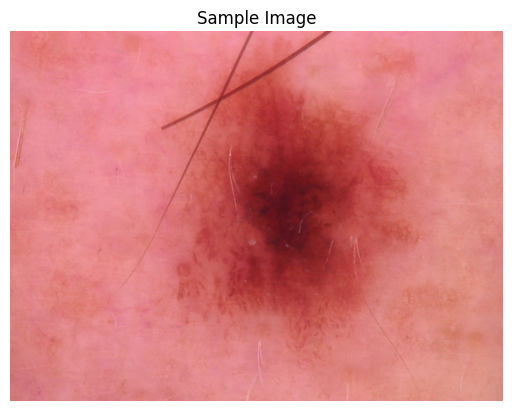

In [8]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load and preprocess image
img_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024306.jpg"  # <-- replace with an actual image from your dataset
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

# Show image
plt.imshow(image)
plt.axis('off')
plt.title("Sample Image")
plt.show()


In [9]:
with torch.no_grad():
    output = model(input_tensor)
    confidence, predicted_class = torch.max(torch.nn.functional.softmax(output, dim=1), 1)

print(f"Predicted Class: {predicted_class.item()}, Confidence: {confidence.item():.4f}")


Predicted Class: 4, Confidence: 0.9416


In [10]:
!pip install grad-cam --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.8 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


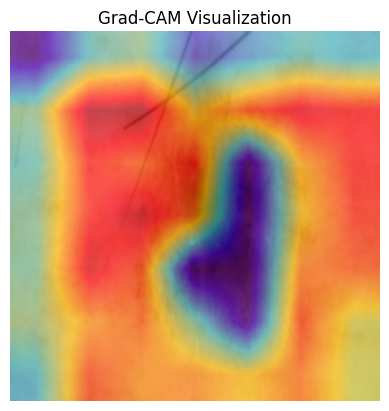

In [12]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define target layer
target_layers = [model.layer4[-1]]

# Initialize GradCAM (without use_cuda)
cam = GradCAM(model=model, target_layers=target_layers)

# Create target for predicted class
targets = [ClassifierOutputTarget(predicted_class.item())]

# Run GradCAM on input
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0]  # Get the CAM for first (and only) image

# Convert input tensor to numpy [H, W, C] and normalize to [0,1]
input_numpy = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
input_numpy = (input_numpy - input_numpy.min()) / (input_numpy.max() - input_numpy.min())

# Overlay CAM on original image
visualization = show_cam_on_image(input_numpy, grayscale_cam, use_rgb=True)

# Display result
plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM Visualization")
plt.show()


In [13]:
import torch.nn.functional as F

def evaluate_faithfulness(model, input_tensor, grayscale_cam, predicted_class, device):
    """
    input_tensor: [1, C, H, W]
    grayscale_cam: [H, W] in range [0, 1]
    predicted_class: int
    """
    model.eval()
    
    # Normalize grayscale cam between 0-1
    cam_mask = torch.tensor(grayscale_cam).unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]
    cam_mask = F.interpolate(cam_mask, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)  # Resize

    # Normalize cam mask
    cam_mask = cam_mask / (cam_mask.max() + 1e-8)

    # Mask input with GradCAM heatmap
    masked_input = input_tensor * cam_mask  # Emphasize important regions

    # Run predictions
    with torch.no_grad():
        orig_logits = model(input_tensor.to(device))
        masked_logits = model(masked_input.to(device))

    # Softmax to get probabilities
    orig_prob = F.softmax(orig_logits, dim=1)[0, predicted_class].item()
    masked_prob = F.softmax(masked_logits, dim=1)[0, predicted_class].item()

    # Compute metrics
    avg_drop = max(0, orig_prob - masked_prob) / orig_prob * 100
    confidence_increase = 1 if masked_prob > orig_prob else 0

    return orig_prob, masked_prob, avg_drop, confidence_increase


In [14]:
orig_prob, masked_prob, avg_drop, conf_increase = evaluate_faithfulness(
    model, input_tensor, grayscale_cam, predicted_class, device
)

print(f"Original Confidence: {orig_prob:.4f}")
print(f"Masked Confidence: {masked_prob:.4f}")
print(f"Average Drop: {avg_drop:.2f}%")
print(f"Confidence Increase: {'Yes' if conf_increase else 'No'}")


Original Confidence: 0.9416
Masked Confidence: 0.9847
Average Drop: 0.00%
Confidence Increase: Yes


In [28]:
print("grayscale_cam shape:", grayscale_cam.shape)

# Check if it's already 3D: (1, H, W)
if grayscale_cam.ndim == 3:
    grayscale_cam_image = grayscale_cam[0]  # Grab the 2D [H, W]
elif grayscale_cam.ndim == 2:
    grayscale_cam_image = grayscale_cam  # Already [H, W]
else:
    raise ValueError(f"Unexpected grayscale_cam shape: {grayscale_cam.shape}")


grayscale_cam shape: (224, 224)


In [26]:
import torch.nn.functional as F

def evaluate_faithfulness(model, input_tensor, grayscale_cam_image, predicted_class, device):
    """
    grayscale_cam_image: expected to be 2D (H, W) CAM heatmap
    """
    model.eval()

    # Ensure it's 2D
    if grayscale_cam_image.ndim != 2:
        raise ValueError(f"Expected grayscale_cam to be 2D (H, W), got shape {grayscale_cam_image.shape}")

    # Convert to tensor and resize to input image size
    cam_mask = torch.tensor(grayscale_cam_image).float().unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]
    cam_mask = F.interpolate(cam_mask, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

    cam_mask = cam_mask / (cam_mask.max() + 1e-8)  # Normalize to [0, 1]
    masked_input = input_tensor * cam_mask  # Emphasize important regions

    with torch.no_grad():
        orig_logits = model(input_tensor.to(device))
        masked_logits = model(masked_input.to(device))

    orig_prob = F.softmax(orig_logits, dim=1)[0, predicted_class].item()
    masked_prob = F.softmax(masked_logits, dim=1)[0, predicted_class].item()

    avg_drop = max(0, orig_prob - masked_prob) / orig_prob * 100
    confidence_increase = 1 if masked_prob > orig_prob else 0
    confidence_increase_pct = ((masked_prob - orig_prob) / orig_prob * 100) if confidence_increase else 0.0

    return orig_prob, masked_prob, avg_drop, confidence_increase, confidence_increase_pct


In [29]:
orig_conf, masked_conf, avg_drop, conf_inc, conf_inc_pct = evaluate_faithfulness(
    model, input_tensor, grayscale_cam_image, predicted_class, device
)


In [30]:
import torch.nn.functional as F
import torch

def evaluate_faithfulness(model, input_tensor, grayscale_cam_image, predicted_class, device):
    """
    Evaluates Grad-CAM faithfulness on a single input.

    Args:
        model: The trained model.
        input_tensor: Input image tensor [1, C, H, W].
        grayscale_cam_image: 2D GradCAM heatmap [H, W] in range [0, 1].
        predicted_class: Class index predicted by the model.
        device: 'cuda' or 'cpu'.

    Returns:
        orig_conf: Confidence on original image.
        masked_conf: Confidence on masked image.
        avg_drop: Average drop in confidence (%).
        conf_inc: 1 if confidence increased, 0 otherwise.
        conf_inc_pct: Confidence increase percentage.
    """
    model.eval()

    if grayscale_cam_image.ndim != 2:
        raise ValueError(f"Expected grayscale_cam to be 2D (H, W), got shape {grayscale_cam_image.shape}")

    # Convert CAM to tensor and resize to input shape
    cam_mask = torch.tensor(grayscale_cam_image).float().unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, H, W]
    cam_mask = F.interpolate(cam_mask, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

    # Normalize the mask
    cam_mask = cam_mask / (cam_mask.max() + 1e-8)

    # Apply the mask
    masked_input = input_tensor * cam_mask

    # Get predictions
    with torch.no_grad():
        orig_logits = model(input_tensor.to(device))
        masked_logits = model(masked_input.to(device))

    orig_prob = F.softmax(orig_logits, dim=1)[0, predicted_class].item()
    masked_prob = F.softmax(masked_logits, dim=1)[0, predicted_class].item()

    avg_drop = max(0, orig_prob - masked_prob) / orig_prob * 100
    conf_inc = 1 if masked_prob > orig_prob else 0
    conf_inc_pct = (masked_prob - orig_prob) / orig_prob * 100 if conf_inc else 0

    return orig_prob, masked_prob, avg_drop, conf_inc, conf_inc_pct


In [31]:
orig_conf, masked_conf, avg_drop, conf_inc, conf_inc_pct = evaluate_faithfulness(
    model, input_tensor, grayscale_cam_image, predicted_class, device
)

print(f"Original Confidence: {orig_conf:.4f}")
print(f"Masked Confidence: {masked_conf:.4f}")
print(f"Average Drop: {avg_drop:.2f}%")
print(f"Confidence Increase: {'Yes' if conf_inc else 'No'}")
print(f"Confidence Increase Percentage: {conf_inc_pct:.2f}%")


Original Confidence: 0.9416
Masked Confidence: 0.9847
Average Drop: 0.00%
Confidence Increase: Yes
Confidence Increase Percentage: 4.57%


In [32]:
import numpy as np

def compute_dice_iou(cam_mask, gt_mask, threshold=0.5):
    """
    Args:
        cam_mask: numpy array [H, W] with values in [0, 1]
        gt_mask: binary ground truth mask [H, W] with values 0 or 1
        threshold: threshold to binarize cam_mask

    Returns:
        dice: Dice coefficient
        iou: Intersection over Union
    """
    cam_bin = (cam_mask >= threshold).astype(np.uint8)
    gt_bin = (gt_mask > 0).astype(np.uint8)

    intersection = np.logical_and(cam_bin, gt_bin).sum()
    union = np.logical_or(cam_bin, gt_bin).sum()
    total = cam_bin.sum() + gt_bin.sum()

    dice = 2 * intersection / (total + 1e-8)
    iou = intersection / (union + 1e-8)

    return dice, iou


In [33]:
def compute_pointing_game_accuracy(cam_mask, gt_mask):
    """
    Args:
        cam_mask: numpy array [H, W], values in [0, 1]
        gt_mask: binary mask [H, W] with object region marked as 1

    Returns:
        accuracy: 1 if max cam point lies within GT mask, else 0
    """
    max_point = np.unravel_index(np.argmax(cam_mask), cam_mask.shape)
    return int(gt_mask[max_point] > 0)


In [35]:
def bbox_to_mask(bbox, shape):
    """
    Converts a bounding box to a binary mask.

    Args:
        bbox: Tuple (x1, y1, x2, y2)
        shape: Tuple (H, W) of the mask size

    Returns:
        Binary mask (H, W)
    """
    x1, y1, x2, y2 = bbox
    mask = np.zeros(shape, dtype=np.uint8)
    mask[y1:y2, x1:x2] = 1
    return mask


In [36]:
bbox = (50, 60, 150, 180)  # (x1, y1, x2, y2)


In [37]:
gt_mask = bbox_to_mask(bbox, grayscale_cam_image.shape)


In [38]:
dice, iou = compute_dice_iou(grayscale_cam_image, gt_mask, threshold=0.3)
pointing_accuracy = compute_pointing_game_accuracy(grayscale_cam_image, gt_mask)

print(f"Dice Score: {dice:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Pointing Game Accuracy: {'Hit' if pointing_accuracy else 'Miss'}")


Dice Score: 0.3140
IoU: 0.1863
Pointing Game Accuracy: Miss
